In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Tue Jan 16 21:41:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   49C    P0   204W / 300W |   6807MiB / 80994MiB |     59%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-9/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


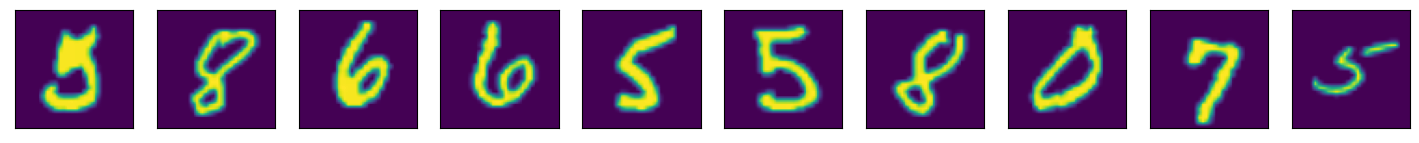

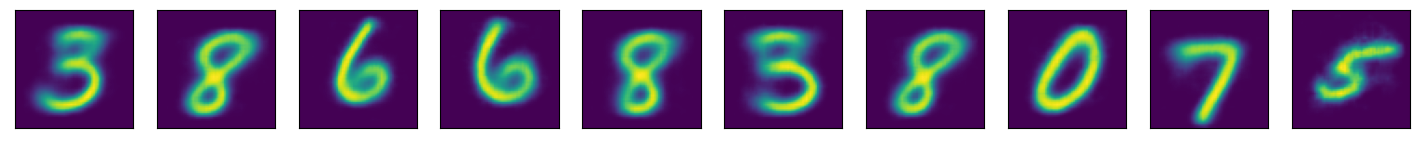

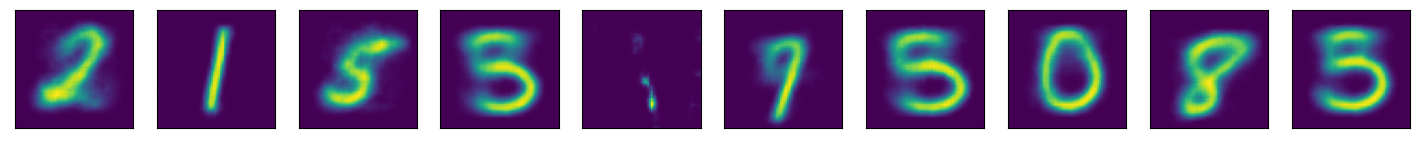

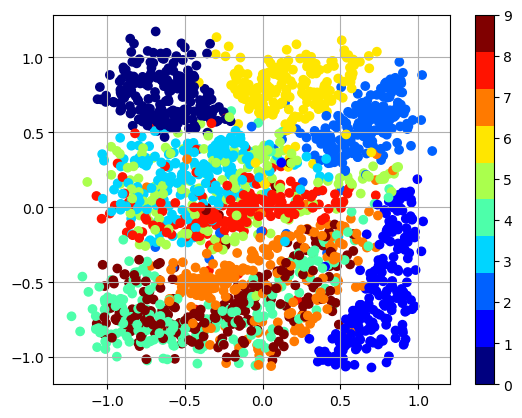

14001
swae_loss 0.0037202023551799355
recon_loss 0.12334747165441513
14002
swae_loss 0.004455785406753421
recon_loss 0.13071401715278624
14003
swae_loss 0.004664913541637361
recon_loss 0.12186735644936561
14004
swae_loss 0.005379741545766592
recon_loss 0.1222710095345974
14005
swae_loss 0.003940847259946168
recon_loss 0.11710512787103652
14006
swae_loss 0.004549684002995491
recon_loss 0.1284591108560562
14007
swae_loss 0.003755136113613844
recon_loss 0.1198889397084713
14008
swae_loss 0.005321273673325777
recon_loss 0.11822926327586174
14009
swae_loss 0.0051306812325492505
recon_loss 0.12161861956119538
14010
swae_loss 0.004007031884975731
recon_loss 0.12231346368789672
14011
swae_loss 0.0035156146972440184
recon_loss 0.12369770929217339
14012
swae_loss 0.004679443757049739
recon_loss 0.12491770312190056
14013
swae_loss 0.004861834971234202
recon_loss 0.1181346133351326
14014
swae_loss 0.004246643395163119
recon_loss 0.12359214723110198
14015
swae_loss 0.003935758373700082
recon_loss 0

swae_loss 0.003841638518497348
recon_loss 0.11482111886143684
14123
swae_loss 0.004519543331116438
recon_loss 0.1207991324365139
14124
swae_loss 0.004042828013189137
recon_loss 0.12136194854974747
14125
swae_loss 0.005256610154174268
recon_loss 0.12327008172869683
14126
swae_loss 0.004454707494005561
recon_loss 0.11678664237260819
14127
swae_loss 0.0041048941668123005
recon_loss 0.119082061201334
14128
swae_loss 0.004510334110818803
recon_loss 0.11536701843142509
14129
swae_loss 0.0037632412975654008
recon_loss 0.11995527744293213
14130
swae_loss 0.004019802086986601
recon_loss 0.12175368592143058
14131
swae_loss 0.003915668872650713
recon_loss 0.11842778697609901
14132
swae_loss 0.004451201530173421
recon_loss 0.12290388345718384
14133
swae_loss 0.004537703632377088
recon_loss 0.11604201719164849
14134
swae_loss 0.0035819569835439324
recon_loss 0.12264899089932442
14135
swae_loss 0.00473683844320476
recon_loss 0.11393299624323845
14136
swae_loss 0.0033952446421608327
recon_loss 0.1182

swae_loss 0.0035573640489019454
recon_loss 0.12147618308663369
14244
swae_loss 0.0027532524429261683
recon_loss 0.11817654445767403
14245
swae_loss 0.004744270816445351
recon_loss 0.12521964833140373
14246
swae_loss 0.003846158238593489
recon_loss 0.11974470689892769
14247
swae_loss 0.0036779003450646995
recon_loss 0.11593295708298683
14248
swae_loss 0.0054176781792193655
recon_loss 0.12854432463645935
14249
swae_loss 0.004775878926739097
recon_loss 0.12651495039463043
14250
swae_loss 0.005812067142687738
recon_loss 0.11005858257412911
14251
swae_loss 0.005218592332676053
recon_loss 0.12290977612137795
14252
swae_loss 0.004779269290156663
recon_loss 0.12666923701763153
14253
swae_loss 0.0031541748088784517
recon_loss 0.11911342516541482
14254
swae_loss 0.0036085051367990674
recon_loss 0.11943862661719322
14255
swae_loss 0.004290601192042232
recon_loss 0.1232975035905838
14256
swae_loss 0.003992631495930254
recon_loss 0.11971122100949287
14257
swae_loss 0.00404900792054832
recon_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'swae_loss' in key:
                    loss = loss + data[key] * 10
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        